#Use LRFinder to find the optimum learning rate for training Cifar 10 dataset using a shallower Resnet CNN model , albumentation image augmentation 

### Submitted by Deepak Hazarika  , Parinita Bora , Gurudatta

In [ ]:
!python --version

Python 3.6.9


In [ ]:
!pip install PyDrive

## Import pydrive modules

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)




## Upload the cifar 10 image files from google drive to colab

Instead of downloading the cifar 10 dataset from web , a copy is saved in google drive.

In [ ]:

downloaded = drive.CreateFile({'id':"1fohphdiuj_-zG7EwFnRzj4NQ3rZRu_PY"})   # replace the id with id of file you want to access
downloaded.GetContentFile('cifar10.zip')

In [ ]:
from zipfile import ZipFile

## Extract the images into a local folder

In [ ]:
with ZipFile('/content/cifar10.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

### Initialize the parameters

In [ ]:
EPOCHS = 50
BATCH_SIZE = 128
WEIGHT_DECAY = 1e-2
TRAIN_DATASET_SIZE = 50000
BUCKET_SIZE = 5
NUMBER_OF_BATCHES =  TRAIN_DATASET_SIZE // BATCH_SIZE
NUMBER_OF_BUCKETS = NUMBER_OF_BATCHES // BUCKET_SIZE
DATAFOLDER = "/content/cifar10/"
NUM_LR_FINDER_ITER = 5859 # (i epoch = 50000/batch size , number of iter = iter per epoch * epoch , 50000/128 = 301 , 1954 = 391 * 5)
END_LR = 10
START_LR = 1e-5

## Import the model library from https://github.com/tfdeepnet/visionlib.git

In [ ]:
!git clone https://github.com/tfdeepnet/visionlib.git

fatal: destination path 'visionlib' already exists and is not an empty directory.


In [ ]:
!pip install -e /content/visionlib 


Obtaining file:///content/visionlib
  Found existing installation: visionlib 1.0.0
    Can't uninstall 'visionlib'. No files were found to uninstall.
  Running setup.py develop for visionlib


In [ ]:
import visionlib.models as vl
import visionlib.utils as utl


In [ ]:
!pwd
!ls /content/

/content
adc.json  cifar10  cifar10.zip	sample_data  visionlib


In [ ]:
%matplotlib inline

## Import the libraries

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import cv2
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau

## Prepare a list of albumentation for train and test data 

the following transformations are done on the image before feeding to the network


1.   Padding of (4,4)
2.   RandomCrop 32, 32
3.   FlipHorizontal
4.   CutOut(8, 8)







In [ ]:
import albumentations as A

channel_means = (0.5, 0.5, 0.5)
channel_stdevs = (0.5, 0.5, 0.5)
train_transform_list = [
                        A.PadIfNeeded (min_height=40, min_width=40,border_mode=cv2.BORDER_CONSTANT, value=0 , always_apply=True),
                        A.RandomCrop(32,32),
                        A.HorizontalFlip(),
                        A.Normalize(mean=channel_means, std=channel_stdevs),
                        A.Cutout(num_holes=1, max_h_size=8,max_w_size = 8,p=1)]
# Test Phase transformations
test_transform_list = [A.Normalize(mean=channel_means, std=channel_stdevs)]

##  Use the loaddata utility from visionlib library to load train and test data

In [ ]:
trainloader, testloader = utl.loadalbumentationdata(DATAFOLDER , BATCH_SIZE , train_transform_list, test_transform_list )


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Let us show some of the training images, for fun.



img shape  torch.Size([128, 3, 32, 32])


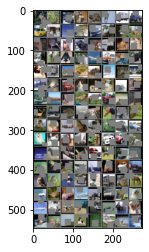

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

print("img shape " , images.shape)


# show images
imshow(torchvision.utils.make_grid(images))
# print labels
#print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Instantiate a DavidResnet model to train and test the cifar 10 dataset


In [ ]:
net = vl.DavidResNet()

### Get the model summary alongwith the recepive field at each layer

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

utl.summary(net.to(device), input_size=(3, 32, 32))

cuda
-----------------------------------------------------------------------------------------------
        Layer (type) |              Output Shape |         Param # |          RF out |         Jump in
            Conv2d-1 |          [-1, 64, 32, 32] |           1,728 |               3 |               1
       BatchNorm2d-2 |          [-1, 64, 32, 32] |             128 |               0 |               0
            Conv2d-3 |         [-1, 128, 32, 32] |          73,728 |               5 |               1
         MaxPool2d-4 |         [-1, 128, 16, 16] |               0 |               6 |               1
       BatchNorm2d-5 |         [-1, 128, 16, 16] |             256 |               0 |               0
            Conv2d-6 |         [-1, 128, 16, 16] |         147,456 |              10 |               2
       BatchNorm2d-7 |         [-1, 128, 16, 16] |             256 |               0 |               0
            Conv2d-8 |         [-1, 128, 16, 16] |         147,456 |       

(tensor(6713674), tensor(6713674))

## Define a Loss function, optimizer 

Let's use a Classification Cross-Entropy loss , SGD with momentum and StepLR to vary the learning rate progressively.



In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=START_LR, weight_decay=WEIGHT_DECAY , momentum=0.9)


## LR finder 

Use the LRfinder to find the learning rate of DavidResnet model under the following setup

1. Batch size = 128
2. Number of iteration = 5859

Plot the lr vs validation accuracy and pick the lr at the point where change in accuracy is the highest.This lr is assumed to be the optimal lr.

Streaming output truncated to the last 5000 lines.


Test set: Average loss: 1.9542, Accuracy: 3223/10000 (32.23%)

iter 4179

Train set: Average loss: 1.5518, Accuracy: 58/128 (45.31%)


Test set: Average loss: 2.0932, Accuracy: 2976/10000 (29.76%)

iter 4180

Train set: Average loss: 1.8186, Accuracy: 40/128 (31.25%)


Test set: Average loss: 1.9223, Accuracy: 3191/10000 (31.91%)

iter 4181

Train set: Average loss: 1.7277, Accuracy: 50/128 (39.06%)


Test set: Average loss: 1.8445, Accuracy: 3564/10000 (35.64%)

iter 4182

Train set: Average loss: 1.4577, Accuracy: 64/128 (50.00%)


Test set: Average loss: 1.8577, Accuracy: 3555/10000 (35.55%)

iter 4183

Train set: Average loss: 1.5588, Accuracy: 56/128 (43.75%)


Test set: Average loss: 2.4608, Accuracy: 2902/10000 (29.02%)

iter 4184

Train set: Average loss: 1.7021, Accuracy: 50/128 (39.06%)


Test set: Average loss: 2.3572, Accuracy: 3082/10000 (30.82%)

iter 4185

Train set: Average loss: 1.5585, Accuracy: 50/128 (39.06%)


Te

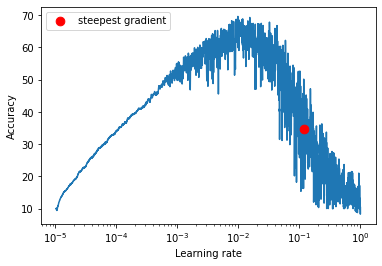

(<matplotlib.axes._subplots.AxesSubplot at 0x7f95857970b8>, 0.1184142291352271)

In [ ]:
lr_finder = utl.LRFinder(net, optimizer, criterion, device="cuda")
lr_finder.range_test(trainloader, val_loader=testloader, end_lr=END_LR, num_iter=NUM_LR_FINDER_ITER ,step_mode="exp")
lr_finder.plot_accuracy() # to inspect the loss-learning rate graph
# to reset the model and optimizer to their initial state

save the historical information of the lrfinder , it contains the lr , test loss and test accuracy.

In [ ]:
import pandas as pd

lr_finder_dict = pd.DataFrame.from_dict(lr_finder.history_accy)

compression_opts = dict(method='zip',

                        archive_name='lrfind_15davidepoch.csv')  

lr_finder_dict.to_csv('outdavid15.zip',  #/content/drive/My Drive/Colab Notebooks/eva/eva5/week10/data/
          index=False,
          compression=compression_opts) 


In [ ]:
lr_finder.reset() 